<h1>Experiment XX: Legacy NW matcher tuning</h1><br>
...explanation should go here...

In [1]:
colab = False
try:
  from google.colab import drive
  drive.mount("/content/gdrive")
  colab = True
  %cd '/content/gdrive/My Drive/python_projects/FYP'
except Exception:
  pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/python_projects/FYP


In [0]:
import numpy as np
from components.classes.NumbaSimpleMatcher import Wrapper as m
from components.classes.SimpleProgressBar import SimpleProgressBar

from components.non_oo_entities import utils as u
import imp
import cv2
import os
import matplotlib.pyplot as plt
import gc
from components.classes.CSVExperimentLogger import CSVExperimentLogger as l
from components.classes.Metrix import Metrix as me
import time

File ./numba_sm/3/numba_sm.csv already exists, header has not been written.
Please select resolution: 0 for small, 1 for medium and 2 for the original image size:


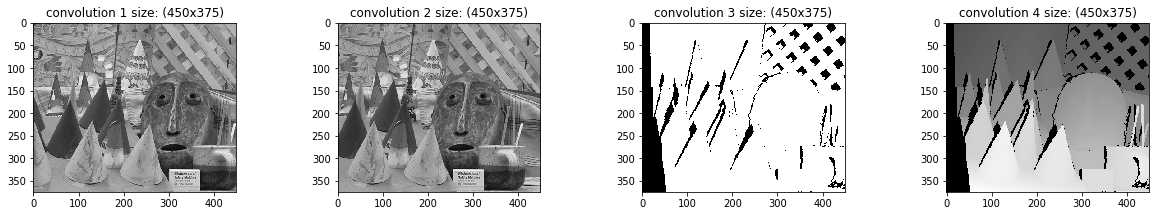

In [3]:
LOG_DIRECTORY = "./numba_sm/4/"
CSV_FILE_NAME =  "numba_sm.csv"
OUTPUT_PATH = LOG_DIRECTORY
CSV_FILE_PATH = os.path.join(LOG_DIRECTORY, CSV_FILE_NAME)
log = l(file_path = CSV_FILE_PATH)
progress_bar = SimpleProgressBar.get_instance()

resolutions = list(["", "H", "F"])
print("Please select resolution: 0 for small, 1 for medium and 2 for the original image size:")
selectedResolutionIndex = 0#int(input())
im2 = cv2.imread("./datasets/middlebury_2003/cones"+resolutions[selectedResolutionIndex]+"/im2.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)
im6 = cv2.imread("./datasets/middlebury_2003/cones"+resolutions[selectedResolutionIndex]+"/im6.ppm", cv2.IMREAD_GRAYSCALE).astype(np.float64)

occlusion_path = "metrix_test/gt/cones_nonocc.png"
occlusion_map = cv2.imread(occlusion_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)

gt_path = "./metrix_test/gt/cones_groundtruth.png"
groundtruth = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
groundtruth_occluded = u.add_occlusions(groundtruth, occlusion_map)/4
u.plotNImages2([im2, im6, occlusion_map,groundtruth_occluded] , cols = 4)    



In [4]:
spec_dict = dict({})
spec_dict["output_folder"] = OUTPUT_PATH
spec_dict["is_parallel"] = "True"
spec_dict["img_name"] = "cones"
spec_dict["alg_type"] =  "simle_numba_matcher"
spec_dict["is_img_preprocessed"] = "False"
spec_dict["convolution_filters"] = "-"
spec_dict["filter_strategy"] = "-"
spec_dict["matching_mode"] = non_occ =  "non_occ"
spec_dict["matrix_init_mode"] = 0
match = spec_dict["match"] = 0
gap = spec_dict["gap"] = 0
egap = spec_dict["egap"] = 0
print("Please define the output image's extension")
spec_dict["ext"] = "png" #input()

Please define the output image's extension


In [5]:
#loop params start/end/step
import math
loop_params = {}
loop_params["match"] = {"start": 150, "end":-10, "step":-10}
loop_params["gap"] = {"start":0, "end":-100, "step":-10}
loop_params["egap"] = {"start":51, "end":-71, "step":-5}

number_of_iterations = 1

for v in loop_params.values():
  temp = math.ceil(abs((v["start"]-v["end"])/v["step"]))
  print(temp)
  number_of_iterations *= temp

number_of_iterations =number_of_iterations
print("The number of iterations based on the params: {0}".format(round(number_of_iterations)))

1
9
25
The number of iterations based on the params: 225


In [6]:
log.write_csv_header()
progress_counter = 1
for m_score in range(loop_params["match"]["start"], loop_params["match"]["end"], loop_params["match"]["step"]):
  for gap_score in range(loop_params["gap"]["start"], loop_params["gap"]["end"], loop_params["gap"]["step"]):
    for egap_score in range(loop_params["egap"]["start"], loop_params["egap"]["end"], loop_params["egap"]["step"]):
      spec_dict["matrix_init_mode"] = 2
      match = spec_dict["match"] = m_score
      gap = spec_dict["gap"] = gap_score
      egap = spec_dict["egap"] = egap_score
      
      
      matcher = m(m_score, gap_score, egap_score)
      matcher.set_images(im6, im2)  
      matcher.configure_instance()      
      tic=time.time()

      x,raw_disp_map = matcher.run_pipeline()
      toc = time.time()
      
      #raw_disp_map = 255-raw_disp_map/(np.max(raw_disp_map))*255
      #inverted_disparity = np.max(raw_disp_map)-raw_disp_map 

      disp_occluded = u.add_occlusions(raw_disp_map, occlusion_map)
      
      #u.plotNImages2([im2, groundtruth_occluded, disp_occluded], cols=3)
      
      wanna_print = False
      spec_dict["runtime"] = toc-tic
      spec_dict["bad1"] = me.bad(disp_occluded, groundtruth_occluded, threshold = 1.0, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)
      spec_dict["bad15"] =0# me.bad(disp_occluded, groundtruth_occluded, threshold = 1.5, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)
      spec_dict["bad2"] = 0#me.bad(disp_occluded, groundtruth_occluded, threshold = 2, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)
      spec_dict["BAD8"] = 0#me.bad(disp_occluded, groundtruth_occluded, threshold = 10.0, non_occ= non_occ, print=wanna_print, occlusion_map = occlusion_map)

      spec_dict["ABS_ERR"] = me.avgerr(disp_occluded, groundtruth_occluded, print=wanna_print, occlusion_map = occlusion_map)

      filename = u.get_output_filename(spec_dict)
      spec_dict["output_file_path"] = os.path.join(spec_dict["output_folder"], filename)
      log.append_new_sm_results(spec_dict)
      #cv2.imwrite(spec_dict["output_file_path"], raw_disp_map)
      progress_bar.progress_bar(progress_counter, number_of_iterations, header= "Parameter search progress: ", progress_bar_steps=60)
      progress_counter+=1
      gc.collect()


File ./numba_sm/3/numba_sm.csv already exists, header has not been written.
Parameter search progress:  [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00 % completed: 225 / 225 steps